In [220]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import numpy as np
import pandas as pd
import math
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [233]:
def plot_projections(ts, points, method_name):
    fig, ax = plt.subplots(figsize=(40, 40))
    ax.set_xlim([ts.min(), ts.max()])
    ax.set_ylim([points.min(), points.max()])
    
    red_patch = mpatches.Patch(color='red', label='X trajectory')
    green_patch = mpatches.Patch(color='green', label='Y trajectory ')
    blue_patch = mpatches.Patch(color='blue', label='Z trajectory')
    
    plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size':30}, loc=2)
    plt.title(method_name, size=30)
    ax.scatter(ts, points[:, 0], color='red', marker=',')
    ax.scatter(ts, points[:, 1], color='green', marker=',')
    ax.scatter(ts, points[:, 2], color='blue', marker=',')
    
def plot3D(points, method_name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(points[:,0],points[:,1],points[:,2])

In [234]:
sigma = 10
b = 8.0/3
r=27
#r in [0..30]
#dx/dt=-sigma*x+sigma*y
#dy/dt=-x*z+r*x-y
#dz/dt=x*y-b*z
def f(vec): 
    x,y,z=vec
    return np.array([-sigma*x+sigma*y, -x*z+r*x-y, x*y-b*z])
start_x=np.array([10.0, -7.0, 4.0])
start_x

array([ 10.,  -7.,   4.])

In [235]:
def euler_method(start_x, t_a=0, t_b=100, dt=0.001):
    cur_t = t_a
    cur_x = np.copy(start_x)
    ts = [cur_t]
    way = [cur_x]
    while cur_t <= t_b:
        cur_x += f(cur_x)*dt
        cur_t += dt
        way += [np.copy(cur_x)]
        ts += [cur_t]
    return (np.array(ts), np.array(way))

In [236]:
ts, points=euler_method(start_x)

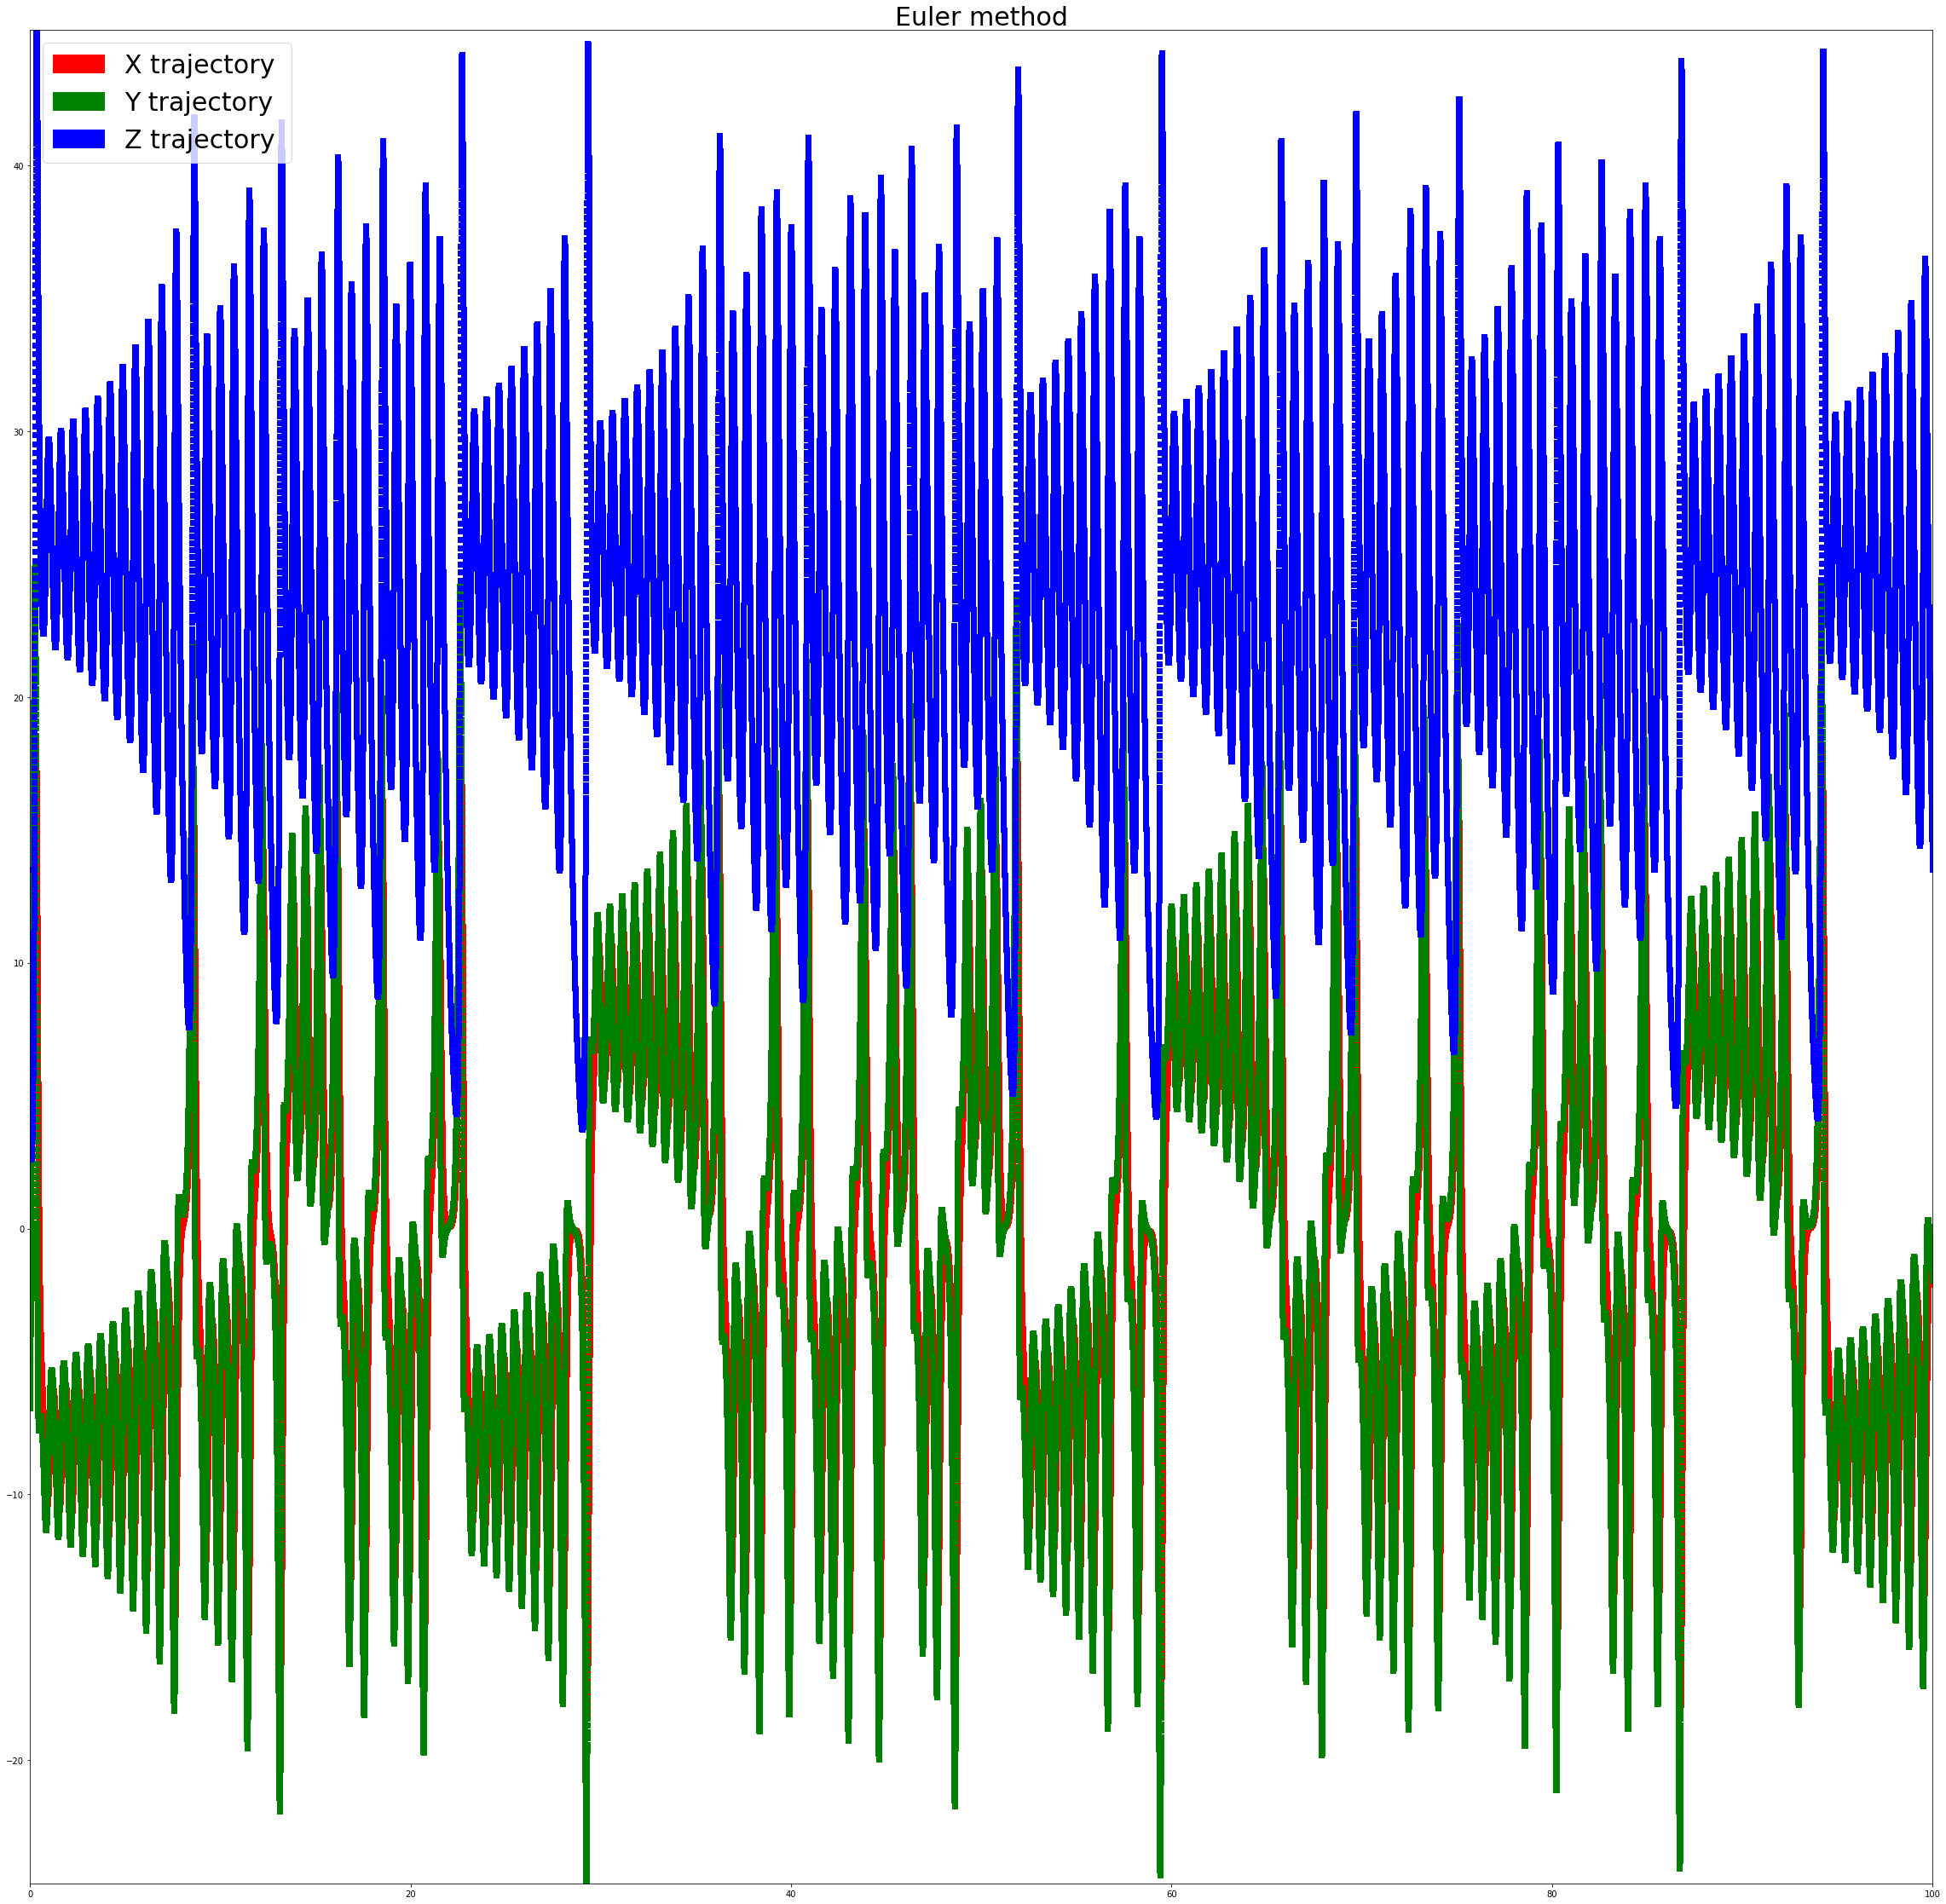

In [237]:
plot_trajectories2D(ts, points, "Euler method")

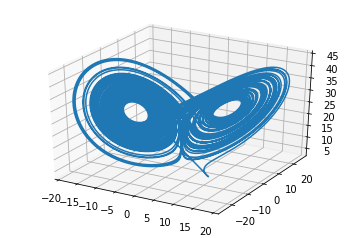

In [238]:
plot3D(points,'Euler method')